Loading data...
Merging and cleaning data...

Top 5 features by correlation with temperature:
et0_fao_evapotranspiration (mm)    0.559086
wind_speed_10m_max (km/h)          0.427584
daylight_duration (s)              0.334067
latitude                           0.328570
shortwave_radiation_sum (MJ/m²)    0.296729
dtype: float64


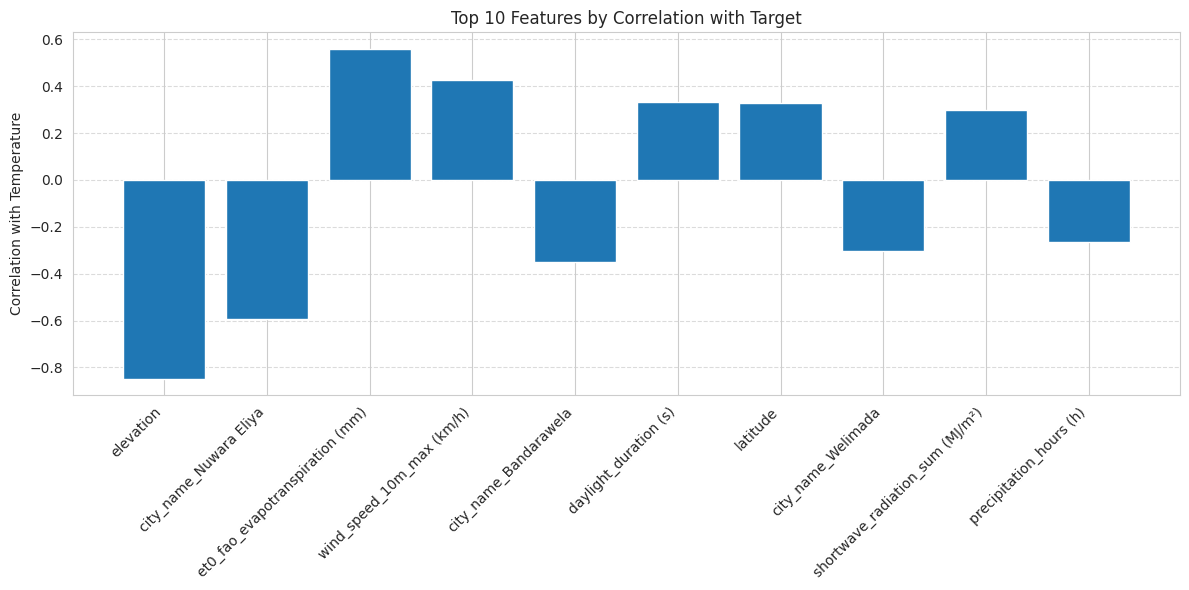


Starting full model training process (Grid Search + Final Fit)...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Grid search completed.
Best parameters: {'C': 10, 'epsilon': 0.2, 'gamma': 'scale'}
Best CV RMSE: 0.58°C
Full training process completed in 335.27 seconds

Model Evaluation Metrics:
MSE: 0.2298
RMSE: 0.4794°C
MAE: 0.3630°C
R² Score: 0.9723


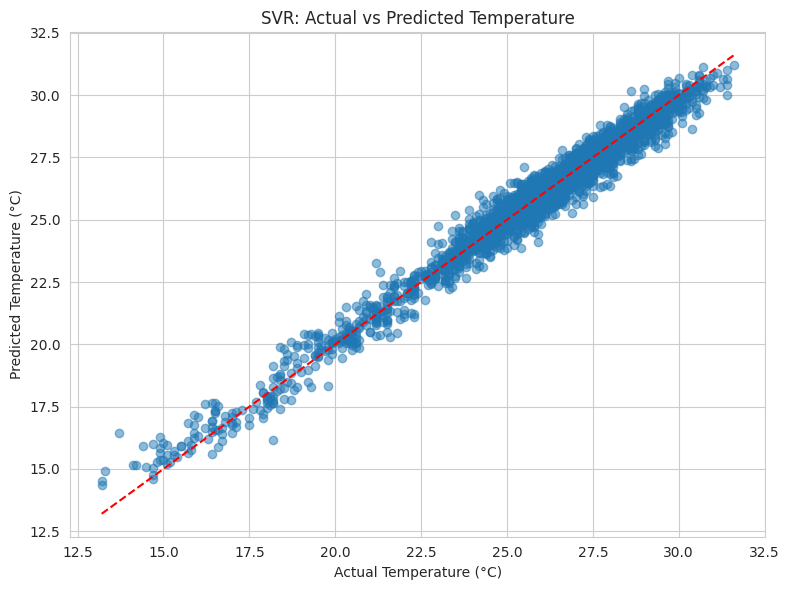

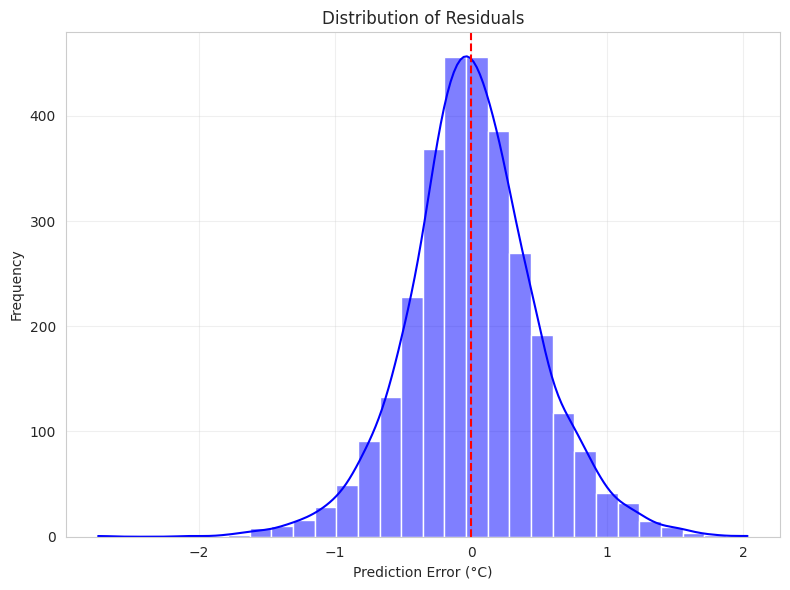

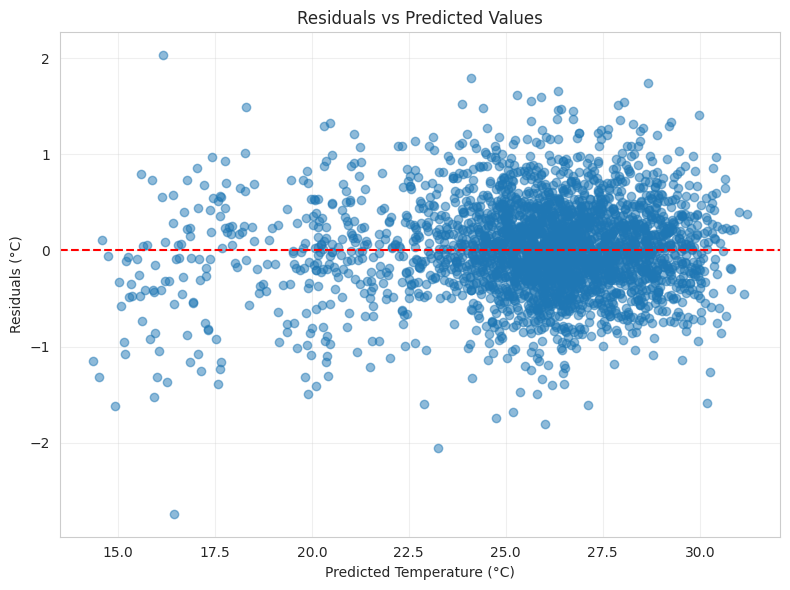


Feature correlation with prediction error:
elevation                          0.123159
city_name_Nuwara Eliya             0.111566
city_name_Bandarawela              0.057413
longitude                          0.032126
shortwave_radiation_sum (MJ/m²)    0.031017
et0_fao_evapotranspiration (mm)    0.024416
city_name_Welimada                 0.022285
city_name_Polonnaruwa              0.022050
city_name_Kegalle                  0.015457
city_name_Moneragala               0.012952
Name: abs_error, dtype: float64


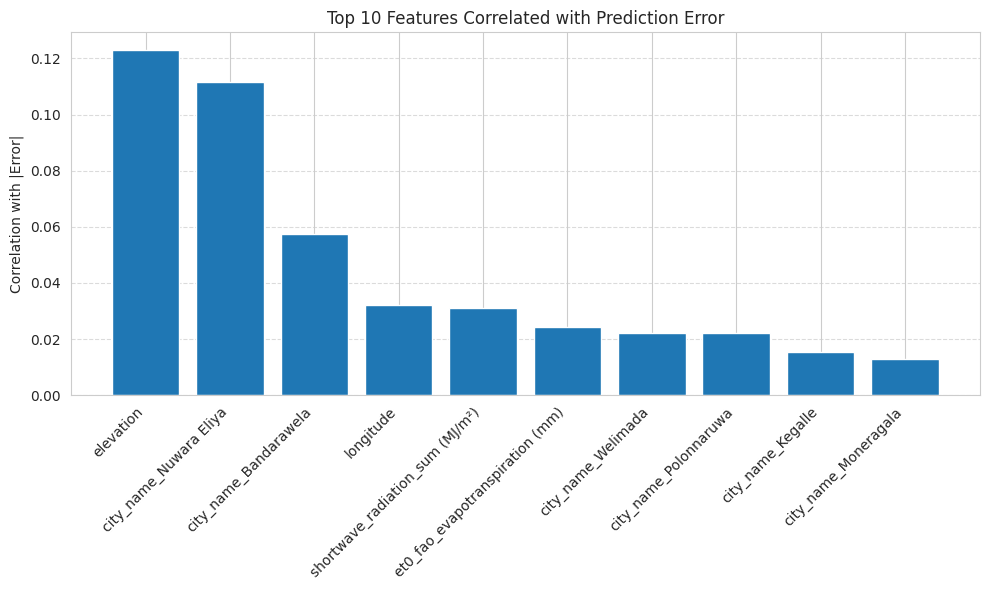


Example Prediction:
Predicted temperature: 32.43°C


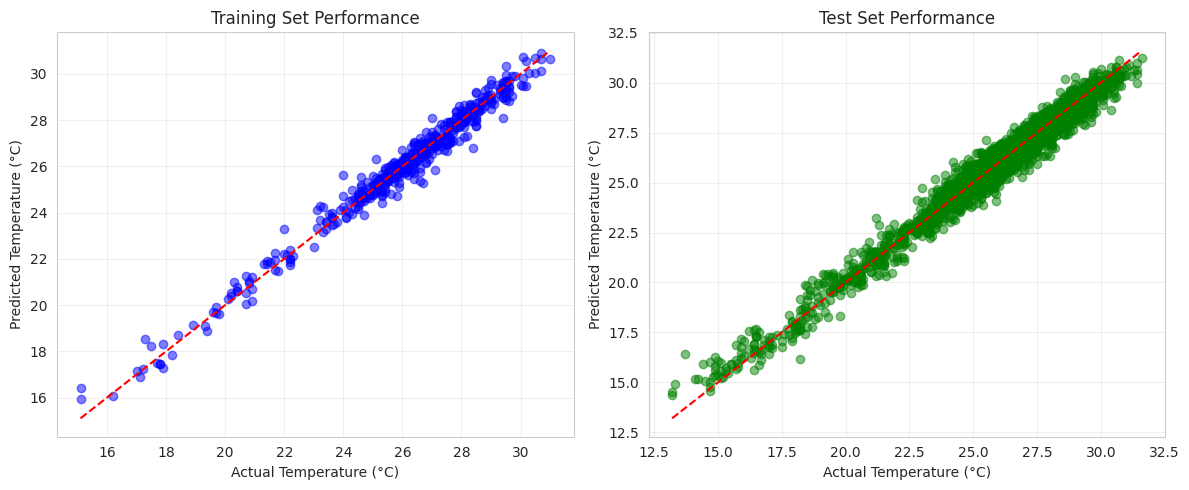


All visualizations completed!


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Load datasets
print("Loading data...")
weather = pd.read_csv('weatherData.csv')
location = pd.read_csv('locationData.csv')

# Strip whitespace from column names
weather.columns = weather.columns.str.strip()
location.columns = location.columns.str.strip()

# Merge and clean data
print("Merging and cleaning data...")
data = pd.merge(weather, location, on='location_id')
data.columns = data.columns.str.strip()

# Define target variable
target = 'temperature_2m_mean (°C)'

drop_cols = [
    'sunrise', 'sunset', 'utc_offset_seconds', 'timezone', 'timezone_abbreviation',
    'weather_code (wmo code)', 'temperature_2m_max (°C)', 'temperature_2m_min (°C)',
    'apparent_temperature_max (°C)', 'apparent_temperature_min (°C)', 'apparent_temperature_mean (°C)'
]
drop_cols_present = [c for c in drop_cols if c in data.columns]
data.drop(columns=drop_cols_present, inplace=True)

# Fill missing values
data.fillna(data.mean(numeric_only=True), inplace=True)

# Encode city names
if 'city_name' in data.columns:
    data = pd.get_dummies(data, columns=['city_name'], drop_first=True)

# Extract date components
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'], errors='coerce')
    data['month'] = data['date'].dt.month
    data['day'] = data['date'].dt.day
    data['day_of_year'] = data['date'].dt.dayofyear
    data.drop(columns=['date'], inplace=True)

# Define features and target
X = data.drop(columns=[target, 'location_id'])
y = data[target]

# Sample data
sample_size = min(15000, len(X))
indices = np.random.choice(len(X), sample_size, replace=False)
X_sample = X.iloc[indices]
y_sample = y.iloc[indices]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Show correlations
correlations = X_train.corrwith(y_train).sort_values(ascending=False)
print("\nTop 5 features by correlation with temperature:")
print(correlations.head(5))

# Plot feature correlations with target
plt.figure(figsize=(12, 6))
top_corrs = correlations.abs().sort_values(ascending=False).head(10)
top_corrs_withsign = correlations[top_corrs.index]
bars = plt.bar(top_corrs_withsign.index, top_corrs_withsign.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Correlation with Temperature')
plt.title('Top 10 Features by Correlation with Target')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
# SVR parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2],
    'gamma': ['scale', 'auto', 0.1]
}

# Grid search sample size
grid_sample_size = min(5000, len(X_train))
if len(X_train) > grid_sample_size:
    grid_indices = np.random.choice(len(X_train), grid_sample_size, replace=False)
    X_grid_train = X_train_scaled[grid_indices]
    y_grid_train = y_train.iloc[grid_indices].values
else:
    X_grid_train = X_train_scaled
    y_grid_train = y_train.values

# Grid search and final training combined timing
print("\nStarting full model training process (Grid Search + Final Fit)...")
full_train_start = time.time()

# Grid search
svr = SVR(kernel='rbf')
grid = GridSearchCV(
    svr, param_grid, cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1, verbose=1
)
grid.fit(X_grid_train, y_grid_train)
print("Grid search completed.")
print("Best parameters:", grid.best_params_)
print(f"Best CV RMSE: {(-grid.best_score_)**0.5:.2f}°C")

# Final model training
best_params = grid.best_params_
final_model = SVR(kernel='rbf', **best_params)
final_model.fit(X_train_scaled, y_train)

full_train_end = time.time()
print(f"Full training process completed in {full_train_end - full_train_start:.2f} seconds")

# Predict
y_pred = final_model.predict(X_test_scaled)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Evaluation Metrics:")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}°C")
print(f"MAE: {mae:.4f}°C")
print(f"R² Score: {r2:.4f}")

# Plot for Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Temperature (°C)')
plt.ylabel('Predicted Temperature (°C)')
plt.title('SVR: Actual vs Predicted Temperature')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig('temperature_prediction_results.png')
plt.close()

# Plot for Residuals histogram with KDE
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, color='blue', bins=30)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Distribution of Residuals')
plt.xlabel('Prediction Error (°C)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('error_distribution.png')
plt.close()

# Plot for Residuals scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Temperature (°C)')
plt.ylabel('Residuals (°C)')
plt.title('Residuals vs Predicted Values')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('residuals_vs_predicted.png')
plt.close()

# Feature error correlation
error_abs = np.abs(residuals)
error_series = pd.Series(error_abs, index=y_test.index)
feature_df = X_test.copy()
feature_df['abs_error'] = error_series
error_correlations = feature_df.corr()['abs_error'].drop('abs_error').sort_values(ascending=False)
print("\nFeature correlation with prediction error:")
print(error_correlations.head(10))

# Plot for Features most correlated with prediction errors
plt.figure(figsize=(10, 6))
top_error_corrs = error_correlations.head(10)
bars = plt.bar(top_error_corrs.index, top_error_corrs.values)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Correlation with |Error|')
plt.title('Top 10 Features Correlated with Prediction Error')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
plt.savefig('error_correlations.png')
plt.close()

# Prediction function
def predict_temperature(features_df, model=final_model, scaler=scaler):
    required_features = X_train.columns
    missing_features = set(required_features) - set(features_df.columns)
    if missing_features:
        print(f"Warning: Missing features: {missing_features}")
        for feature in missing_features:
            features_df[feature] = 0
    features_df = features_df[required_features]
    features_scaled = scaler.transform(features_df)
    return model.predict(features_scaled)

# Example prediction
example_data = pd.DataFrame({
    'daylight_duration (s)': [43200],
    'sunshine_duration (s)': [25000],
    'precipitation_sum (mm)': [0.5],
    'rain_sum (mm)': [0.5],
    'precipitation_hours (h)': [2],
    'wind_speed_10m_max (km/h)': [12.4],
    'wind_gusts_10m_max (km/h)': [18.6],
    'wind_direction_10m_dominant (°)': [180],
    'shortwave_radiation_sum (MJ/m²)': [15.3],
    'et0_fao_evapotranspiration (mm)': [4.2],
    'latitude': [6.9271],
    'longitude': [79.8612],
    'elevation': [7],
    'month': [4],
    'day': [15],
    'day_of_year': [105]
})
for col in X_train.columns:
    if 'city_name_' in col and col not in example_data.columns:
        example_data[col] = 0

# Predict and print
predicted_temp = predict_temperature(example_data)
print(f"\nExample Prediction:\nPredicted temperature: {predicted_temp[0]:.2f}°C")

# Plot for Training vs Test Performance
sample_indices = np.random.choice(len(X_train), min(500, len(X_train)), replace=False)
X_train_sample = X_train_scaled[sample_indices]
y_train_sample = y_train.iloc[sample_indices]
y_train_pred = final_model.predict(X_train_sample)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_train_sample, y_train_pred, alpha=0.5, color='blue')
plt.plot([y_train_sample.min(), y_train_sample.max()],
         [y_train_sample.min(), y_train_sample.max()], 'r--')
plt.xlabel('Actual Temperature (°C)')
plt.ylabel('Predicted Temperature (°C)')
plt.title('Training Set Performance')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.5, color='green')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Temperature (°C)')
plt.ylabel('Predicted Temperature (°C)')
plt.title('Test Set Performance')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig('train_test_comparison.png')
plt.close()

print("\nAll visualizations completed!")